In [224]:
import nltk
import string
from progressbar import ProgressBar
from pymongo import MongoClient

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

In [225]:
# nltk.download()

In [226]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

In [227]:
client = MongoClient()
db = client.legislation
bills = db.bills

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')
pbar = ProgressBar()

In [228]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [229]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [230]:
from nltk.corpus import stopwords

def analyze(text):
    # preprocess
    cleaned = text.lower()
    # remove stop words and punctuation
    tokens = nltk.word_tokenize(text)
    stop = stopwords.words('english') + list(string.punctuation)
    stopped = [i for i in tokens if i not in stop]
    # stem tokens
    stems = stem_tokens(tokens, stemmer)
    # get bigrams, trigrams
    bigrams = BigramCollocationFinder.from_words(stopped)
    trigrams = TrigramCollocationFinder.from_words(stopped)
    # exclude bigrams if included in trigram
    # only bigrams that appear 3+ times
#     bigrams.apply_freq_filter(3)
#     trigrams.apply_freq_filter(3)
    # return the 10 n-grams with the highest PMI
    bigrams = bigrams.nbest(bigram_measures.pmi, 10)
    trigrams = trigrams.nbest(trigram_measures.pmi, 10)
    exclude = set()
    for g in trigrams:
        exclude |= {g[:2], g[1:]}
    for i, b in enumerate(bigrams):
        if b in exclude: bigrams.pop(i)
#     bigrams = [i for i in bigrams if all(word in bigrams for word in trigrams)]
    tokens = stopped + bigrams + trigrams
    return tokens

analyze("hi there hows it going today. lovely isn't it? how about you tell me your name")



['hi',
 'hows',
 'going',
 'today',
 'lovely',
 "n't",
 'tell',
 'name',
 ('hi', 'hows'),
 ('lovely', "n't"),
 ('tell', 'name'),
 ('going', 'today', 'lovely'),
 ('hi', 'hows', 'going'),
 ('hows', 'going', 'today'),
 ('lovely', "n't", 'tell'),
 ("n't", 'tell', 'name'),
 ('today', 'lovely', "n't")]

In [286]:
selection = list(bills.find({},{"text_versions":1, "bill_id":1}).limit(1000))

In [287]:
texts = [(i["bill_id"], i['text_versions'].itervalues().next()) for i in selection]
# make lowercase, remove punctuation
cleaned = [(bill, text
               .encode('utf-8')
               .lower()
               .translate(None, string.punctuation))
               for bill, text in texts]

In [233]:
#really only want to stem and remove punctuation when predicting. not when summarizing

In [288]:
# vectorizer = TfidfVectorizer(sublinear_tf=True, analyzer=analyze)
vectorizer = TfidfVectorizer(min_df=2, sublinear_tf=True, tokenizer=tokenize, stop_words='english', ngram_range=(1,3))
# vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), lowercase=True, )
docs = vectorizer.fit_transform([i[1] for i in cleaned])

In [289]:
len(vectorizer.get_feature_names())

90094

In [263]:
feature_names = vectorizer.get_feature_names()
for index, doc in enumerate(docs):
    if index == 20: break
    print
    print("Top words in bill: {0}".format(cleaned[index][0]))
    scores = {feature_names[col]: doc[0, col] for col in doc.nonzero()[1]}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:9]:
         print("Word: {}, TF-IDF: {}".format(word, round(score, 4)))


Top words in bill: hr4053-106
Word: republ, TF-IDF: 0.1186
Word: democrat, TF-IDF: 0.0975
Word: democraci, TF-IDF: 0.0965
Word: kosovo, TF-IDF: 0.0955
Word: act 1989, TF-IDF: 0.0832
Word: tribun, TF-IDF: 0.0802
Word: 1989, TF-IDF: 0.0786
Word: seed, TF-IDF: 0.0786
Word: media, TF-IDF: 0.0786

Top words in bill: hr4009-106
Word: gun, TF-IDF: 0.0775
Word: firearm, TF-IDF: 0.0697
Word: handgun, TF-IDF: 0.0664
Word: licens dealer, TF-IDF: 0.0628
Word: licens manufactur, TF-IDF: 0.0628
Word: licens manufactur licens, TF-IDF: 0.0628
Word: dealer, TF-IDF: 0.0628
Word: licens import licens, TF-IDF: 0.0628
Word: ammunit, TF-IDF: 0.0628

Top words in bill: hr4013-106
Word: nutrient, TF-IDF: 0.1161
Word: sediment, TF-IDF: 0.1146
Word: upper, TF-IDF: 0.1142
Word: basin, TF-IDF: 0.0994
Word: mississippi, TF-IDF: 0.0933
Word: river, TF-IDF: 0.0874
Word: advisori, TF-IDF: 0.0734
Word: work group, TF-IDF: 0.0729
Word: secretari agricultur, TF-IDF: 0.0706

Top words in bill: hr4029-106
Word: alzheim, 

In [290]:
#returns the most interesting collocations according to frequency and pmi
# change this to read in your data
finder = BigramCollocationFinder.from_words(
    nltk.word_tokenize(cleaned[0][1])
    )

# only bigrams that appear 3+ times
finder.apply_freq_filter(3) 

# return the 10 n-grams with the highest PMI
finder.nbest(bigram_measures.pmi, 10) 

[('legal', 'protection'),
 ('american', 'university'),
 ('nongovernmental', 'organizations'),
 ('north', 'atlantic'),
 ('atlantic', 'treaty'),
 ('less', 'than'),
 ('marketbased', 'economy'),
 ('equitable', 'burdensharing'),
 ('treaty', 'organization'),
 ('organization', 'nato')]

In [291]:
# top four trigrams spanning five words
finder = TrigramCollocationFinder.from_words(
    nltk.word_tokenize(cleaned[0][1]), window_size=5)
# filter results to allow 'and' to appear between words but not on the edge
finder.apply_ngram_filter(lambda w1, w2, w3: 'and' in (w1, w3))
sorted(finder.nbest(trigram_measures.raw_freq, 10))


[('in', 'the', 'of'),
 ('of', 'the', 'of'),
 ('of', 'the', 'republic'),
 ('republic', 'of', 'montenegro'),
 ('republic', 'of', 'the'),
 ('the', 'of', 'montenegro'),
 ('the', 'of', 'serbia'),
 ('the', 'of', 'the'),
 ('the', 'republic', 'montenegro'),
 ('the', 'republic', 'of')]

In [292]:
# get the context for a word in a document
text = cleaned[0][1]
words = nltk.word_tokenize(text)
textobj = nltk.Text(words)
textobj.concordance('amount')

Displaying 21 of 21 matches:
ies of southeastern europe from the amount appropriated for fiscal year 2001 t
 of the republic of serbia from the amount appropriated for fiscal year 2001 t
ctly humanitarian purposes from the amount appropriated for fiscal year 2001 t
nts for serbia and montenegroof the amount appropriated for fiscal year 2001 t
anding section 103c of this act the amount appropriated for fiscal year 2001 t
o the republic of montenegro of the amount appropriated for fiscal year 2001 t
conomic and political reformsof the amount appropriated for fiscal year 2001 t
ssistance for microenterpriseof the amount made available under subsection a t
itiative and related projectsof the amount made available under subsection a 5
gn military financing programof the amount made available under subsection a n
litary education and trainingof the amount made available under subsection a t
president shall make available such amount as is necessary and appropriate for
her provision of this a

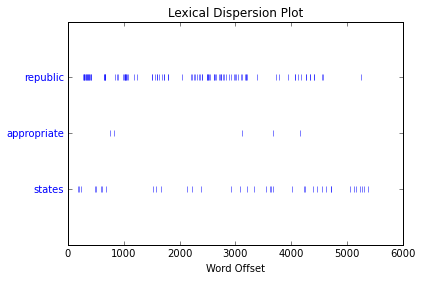

In [295]:
# plot of where in a document words appear
%matplotlib inline
textobj.dispersion_plot(['republic', 'appropriate', 'states'])

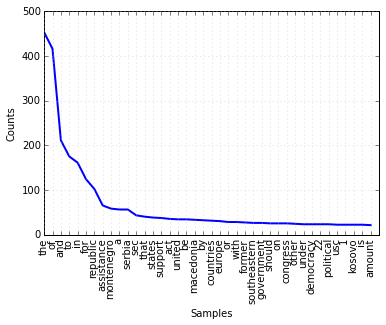

In [296]:
textobj.plot(40)

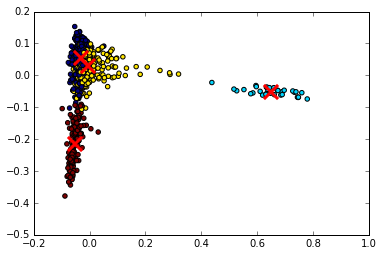

In [298]:
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4).fit(X)
centers2D = pca.transform(kmeans.cluster_centers_)

from sklearn.decomposition import PCA
X=docs.toarray()

pca = PCA(n_components=4).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=kmeans.labels_)



plt.hold(True)
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')

In [279]:
import pickle
with open('sentence_tokenizer_params.pickle') as f:
    params = pickle.load(f)

In [280]:
params.sent_starters

{u'_______________________________________________________________________',
 u'be',
 u'however',
 u'nothing',
 u'passed',
 u'there',
 u'this'}

In [281]:
import pickle
with open('sentence_tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

In [282]:
# using the sentences in a single document to make clusters with custom tokenizer
selection = bills.find_one({},{"text_versions":1, "bill_id":1, "official_title":1})
text = selection['text_versions'].itervalues().next()
sentences = tokenizer.tokenize(text)

with open('comp2.txt', 'wb') as f:
    for i in sentences:
        f.write('\n***\n')
        f.write(i)

In [283]:
# words = nltk.word_tokenize(text)
# custom_stop = ['sec', 'seq', 'title', 'congress', 'u.s.c']
# stop_words = nltk.corpus.stopwords.words('english') + custom_stop
# stopped = [i.lower() for i in words if i.lower() not in stop_words]
# nltk.FreqDist(stopped).most_common(50)

def tokenize(text):
    words = nltk.word_tokenize(text)
    custom_stop = ['sec'] #, 'seq', 'title', 'congress',]
    stop_words = nltk.corpus.stopwords.words('english') + custom_stop
    stopped = [i.lower() for i in words if i.lower() not in stop_words]
    return stopped

In [284]:
vectorizer = TfidfVectorizer(sublinear_tf=True, tokenizer=tokenize, stop_words='english', ngram_range=(1,3), lowercase=True)
docs = vectorizer.fit_transform(sentences)

In [ ]:
# using a corpus of 10,000 different bills to make clusters
# instead of clustering on sentences of individual bills
selection = list(bills.find({},{"text_versions":1, "bill_id":1, "official_title":1}).limit(10000))
texts = [(i["bill_id"], i['text_versions'].itervalues().next()) for i in selection]
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, stop_words='english', lowercase=True)
docs = vectorizer.fit_transform([i[1] for i in texts])

In [285]:
from sklearn.metrics import pairwise_distances

k_clusters = 20
km = MiniBatchKMeans(init='k-means++', n_init=1, init_size=1000,
                     batch_size=1000, n_clusters=k_clusters)
model = km.fit(X)

NameError: name 'MiniBatchKMeans' is not defined